In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#导入模块包
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt

####Data Fields (as provided by Kaggle):
1. datetime: hourly date + timestamp
2. season: *(indices changed from defaults received)
  - 1 = winter
  - 2 = spring
  - 3 = summer
  - 4 = fall
3. holiday - whether the day is considered a holiday
4. workingday - whether the day is neither a weekend nor holiday
5. weather - encoded to make explicit various extreme weather events
6. temp - temperature in Celsius
7. atemp - "feels like" temperature in Celsius
8. humidity - relative humidity
9. windspeed - wind speed
10. casual - number of non-registered user rentals initiated
11. registered - number of registered user rentals initiated
12. count - number of total rentals

In [67]:
##导入数据,这样处理可以一起对数据进行特征处理
dfs = {}
for name in ['train', 'test']:
    df = pd.read_csv('../data/%s.csv' % name)
    df['_data'] = name
    dfs[name] = df

In [68]:
# combine train and test data into one df
df = dfs['train'].append(dfs['test'])

# lowercase column names
df.columns = map(str.lower, df.columns)
df.head()

,_data,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
0,train,14.395,3,16,2011-01-01 00:00:00,0,81,13,1,9.84,1,0,0
1,train,13.635,8,40,2011-01-01 01:00:00,0,80,32,1,9.02,1,0,0
2,train,13.635,5,32,2011-01-01 02:00:00,0,80,27,1,9.02,1,0,0
3,train,14.395,3,13,2011-01-01 03:00:00,0,75,10,1,9.84,1,0,0
4,train,14.395,0,1,2011-01-01 04:00:00,0,75,1,1,9.84,1,0,0


In [69]:
df.dtypes

_data          object
atemp         float64
casual        float64
count         float64
datetime       object
holiday         int64
humidity        int64
registered    float64
season          int64
temp          float64
weather         int64
windspeed     float64
workingday      int64
dtype: object

#1 特征构造


##1.0 数据格式转换，变为log

将数据变为log，可以处理数据长尾性


In [70]:
# logarithmic transformation of dependent cols
# (adding 1 first so that 0 values don't become -inf)
for col in ['casual', 'registered', 'count']:
    df['%s_log' % col] = np.log(df[col] + 1)

##1.1 时间分割

下面主要是时间维度特征的生成，
- 用到了DatetimeIndex()来解析时间
- 可以用df.year来得到年的时间，也可以使用如下：
```
data['year']=[t.year for t in pd.DatetimeIndex(data['datetime'])]
```
- 当然也可以用datetime来解析
```
from datetime import datetime, date, time
data['hour'] = data['datetime'].map(lambda x: (datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).hour)
data['weekday'] = data['datetime'].map(lambda x: (datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).weekday())
data['month'] = data['datetime'].map(lambda x: (datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).month)
```

In [71]:
## parse datetime colum & add new time related columns
dt = pd.DatetimeIndex(df['datetime'])
df.set_index(dt, inplace=True)
df.head()

,_data,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,casual_log,registered_log,count_log
2011-01-01 00:00:00,train,14.395,3,16,2011-01-01 00:00:00,0,81,13,1,9.84,1,0,0,1.386294,2.639057,2.833213
2011-01-01 01:00:00,train,13.635,8,40,2011-01-01 01:00:00,0,80,32,1,9.02,1,0,0,2.197225,3.496508,3.713572
2011-01-01 02:00:00,train,13.635,5,32,2011-01-01 02:00:00,0,80,27,1,9.02,1,0,0,1.791759,3.332205,3.496508
2011-01-01 03:00:00,train,14.395,3,13,2011-01-01 03:00:00,0,75,10,1,9.84,1,0,0,1.386294,2.397895,2.639057
2011-01-01 04:00:00,train,14.395,0,1,2011-01-01 04:00:00,0,75,1,1,9.84,1,0,0,0.000000,0.693147,0.693147


In [72]:
df['date'] = dt.date
df['day'] = dt.day
df['month'] = dt.month
df['year'] = dt.year
df['hour'] = dt.hour
df['dow'] = dt.dayofweek
df['woy'] = dt.weekofyear

In [73]:
df.head()

,_data,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,...,casual_log,registered_log,count_log,date,day,month,year,hour,dow,woy
2011-01-01 00:00:00,train,14.395,3,16,2011-01-01 00:00:00,0,81,13,1,9.84,...,1.386294,2.639057,2.833213,2011-01-01,1,1,2011,0,5,52
2011-01-01 01:00:00,train,13.635,8,40,2011-01-01 01:00:00,0,80,32,1,9.02,...,2.197225,3.496508,3.713572,2011-01-01,1,1,2011,1,5,52
2011-01-01 02:00:00,train,13.635,5,32,2011-01-01 02:00:00,0,80,27,1,9.02,...,1.791759,3.332205,3.496508,2011-01-01,1,1,2011,2,5,52
2011-01-01 03:00:00,train,14.395,3,13,2011-01-01 03:00:00,0,75,10,1,9.84,...,1.386294,2.397895,2.639057,2011-01-01,1,1,2011,3,5,52
2011-01-01 04:00:00,train,14.395,0,1,2011-01-01 04:00:00,0,75,1,1,9.84,...,0.000000,0.693147,0.693147,2011-01-01,1,1,2011,4,5,52


##1.2 季节特征

In [75]:
# add a count_season column using join
by_season = df[df['_data'] == 'train'].groupby('season')[['count']].agg(sum)
by_season.columns = ['count_season']
df = df.join(by_season, on='season')

print by_season

        count_season
season              
1             312498
2             588282
3             640662
4             544034


##1.3 高峰期的特征

下面首先绘制是否工作日的借车情况，构造高峰期的特征:
1. 根据绘制的图可以看到是否workingday存在着不同的高峰期，我们需要区别对待
2. df['peak']是构造高峰期特征，其中lambda x:(0,1)是把true,false限制为0,1

workingday      0      1
hour                    
0           13701  11387
1           10427   4945
2            7686   2573
3            3677   1414
4            1239   1593


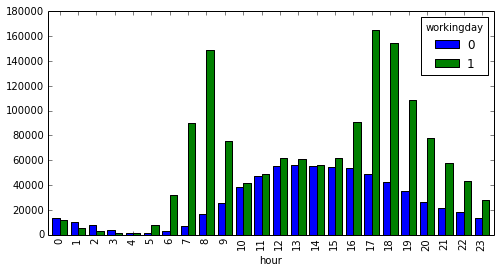

In [76]:
# rentals by hour, split by working day (or not)
by_hour = df[df['_data'] == 'train'].copy().groupby(['hour', 'workingday'])['count'].agg('sum').unstack()
print by_hour.head()
by_hour.plot(kind='bar', figsize=(8,4), width=0.8);

In [77]:
df['peak'] = df[['hour', 'workingday']].apply(lambda x: (0,1)[(x['workingday'] == 1 and  
            ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 12)) 
            or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)

In [78]:
#sandy
df['holiday'] = df[['month', 'day', 'holiday', 'year']].apply(lambda x: (x['holiday'], 1)[x['year'] == 2012 and x['month'] == 10 and (x['day'] in [30])], axis = 1)

#christmas day and others
df['holiday'] = df[['month', 'day', 'holiday']].apply(lambda x: (x['holiday'], 1)[x['month'] == 12 and (x['day'] in [24, 26, 31])], axis = 1)
df['workingday'] = df[['month', 'day', 'workingday']].apply(lambda x: (x['workingday'], 0)[x['month'] == 12 and x['day'] in [24, 31]], axis = 1)

In [79]:
df.head()

,_data,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,...,count_log,date,day,month,year,hour,dow,woy,count_season,peak
2011-01-01 00:00:00,train,14.395,3,16,2011-01-01 00:00:00,0,81,13,1,9.84,...,2.833213,2011-01-01,1,1,2011,0,5,52,312498,0
2011-01-01 01:00:00,train,13.635,8,40,2011-01-01 01:00:00,0,80,32,1,9.02,...,3.713572,2011-01-01,1,1,2011,1,5,52,312498,0
2011-01-01 02:00:00,train,13.635,5,32,2011-01-01 02:00:00,0,80,27,1,9.02,...,3.496508,2011-01-01,1,1,2011,2,5,52,312498,0
2011-01-01 03:00:00,train,14.395,3,13,2011-01-01 03:00:00,0,75,10,1,9.84,...,2.639057,2011-01-01,1,1,2011,3,5,52,312498,0
2011-01-01 04:00:00,train,14.395,0,1,2011-01-01 04:00:00,0,75,1,1,9.84,...,0.693147,2011-01-01,1,1,2011,4,5,52,312498,0


##1.3 天气特征

这里主要增加几个天气特征

In [80]:
df['ideal'] = df[['temp', 'windspeed']].apply(lambda x: (0, 1)[x['temp'] > 27 and x['windspeed'] < 30], axis = 1)
df['sticky'] = df[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)

#3 模型评测

##3.1 大神代码

用了随机森林和GBRT来预测


In [81]:
##RMSE计算
def get_rmsle(y_pred, y_actual):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

In [82]:
def get_data():
    data = df[df['_data'] == 'train'].copy()
    return data

def custom_train_test_split(data, cutoff_day=15):
    train = data[data['day'] <= cutoff_day]
    test = data[data['day'] > cutoff_day]

    return train, test


def prep_data(data, input_cols):
    X = data[input_cols].as_matrix()
    y_r = data['registered_log'].as_matrix()
    y_c = data['casual_log'].as_matrix()

    return X, y_r, y_c
def predict_on_validation_set(model, input_cols):
    data = get_data()

    train, test = custom_train_test_split(data)

    X_train, y_train_r, y_train_c = prep_data(train, input_cols)
    X_test, y_test_r, y_test_c = prep_data(test, input_cols)

    model_r = model.fit(X_train, y_train_r)
    y_pred_r = np.exp(model_r.predict(X_test)) - 1

    model_c = model.fit(X_train, y_train_c)
    y_pred_c = np.exp(model_c.predict(X_test)) - 1

    y_pred_comb = np.round(y_pred_r + y_pred_c)
    y_pred_comb[y_pred_comb < 0] = 0

    y_test_comb = np.exp(y_test_r) + np.exp(y_test_c) - 2

    score = get_rmsle(y_pred_comb, y_test_comb)
    return (y_pred_comb, y_test_comb, score)

df_test = df[df['_data'] == 'test'].copy()

# predict on test set & transform output back from log scale
def predict_on_test_set(model, x_cols):
    # prepare training set
    df_train = df[df['_data'] == 'train'].copy()
    X_train = df_train[x_cols].as_matrix()
    y_train_cas = df_train['casual_log'].as_matrix()
    y_train_reg = df_train['registered_log'].as_matrix()

    # prepare test set
    X_test = df_test[x_cols].as_matrix()

    casual_model = model.fit(X_train, y_train_cas)
    y_pred_cas = casual_model.predict(X_test)
    y_pred_cas = np.exp(y_pred_cas) - 1
    registered_model = model.fit(X_train, y_train_reg)
    y_pred_reg = registered_model.predict(X_test)
    y_pred_reg = np.exp(y_pred_reg) - 1
    # add casual & registered predictions together
    return y_pred_cas + y_pred_reg

随机森林预测，validation的rmse为0.44059

In [83]:
###随机森林

params = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}
rf_model = RandomForestRegressor(**params)
rf_cols = [
    'weather', 'temp', 'atemp', 'windspeed',
    'workingday', 'season', 'holiday', 'sticky',
    'hour', 'dow', 'woy', 'peak'
    ]

(rf_p, rf_t, rf_score) = predict_on_validation_set(rf_model, rf_cols)
print rf_score

0.44059262711


In [84]:
df[rf_cols].corr()

,weather,temp,atemp,windspeed,workingday,season,holiday,sticky,hour,dow,woy,peak
weather,1.000000,-0.102640,-0.105563,0.026226,0.041482,-0.014524,0.008702,0.242225,-0.020203,-0.046424,0.009692,-0.007482
temp,-0.102640,1.000000,0.987672,-0.023125,0.063503,0.312025,-0.068687,-0.010066,0.137603,-0.036220,0.198641,0.095949
atemp,-0.105563,0.987672,1.000000,-0.062336,0.062471,0.319380,-0.071974,0.001853,0.133750,-0.038918,0.205561,0.090360
windspeed,0.026226,-0.023125,-0.062336,1.000000,-0.008332,-0.149773,0.005003,-0.191301,0.137252,0.003274,-0.131613,0.134438
workingday,0.041482,0.063503,0.062471,-0.008332,1.000000,0.021577,-0.259631,0.536900,0.002185,-0.692113,-0.013280,-0.268954
season,-0.014524,0.312025,0.319380,-0.149773,0.021577,1.000000,-0.053686,0.101340,-0.006117,-0.007448,0.814302,-0.006512
holiday,0.008702,-0.068687,-0.071974,0.005003,-0.259631,-0.053686,1.000000,-0.129598,0.003675,-0.183181,0.058053,0.062929
sticky,0.242225,-0.010066,0.001853,-0.191301,0.536900,0.101340,-0.129598,1.000000,-0.186906,-0.397343,0.103407,-0.218928
hour,-0.020203,0.137603,0.133750,0.137252,0.002185,-0.006117,0.003675,-0.186906,1.000000,-0.002893,-0.005437,0.216209
dow,-0.046424,-0.036220,-0.038918,0.003274,-0.692113,-0.007448,-0.183181,-0.397343,-0.002893,1.000000,0.009368,0.189718


GBRT预测

In [85]:
params = {'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'min_samples_leaf' : 10, 'learning_rate': 0.1, 'subsample': 0.7, 'loss': 'ls'}
gbm_model = GradientBoostingRegressor(**params)
gbm_cols = [
    'weather', 'temp', 'atemp', 'humidity', 'windspeed',
    'holiday', 'workingday', 'season',
    'hour', 'dow', 'year', 'ideal', 'count_season',
]

(gbm_p, gbm_t, gbm_score) = predict_on_validation_set(gbm_model, gbm_cols)
print gbm_score

0.317620393716


In [86]:
df[gbm_cols].corr()

,weather,temp,atemp,humidity,windspeed,holiday,workingday,season,hour,dow,year,ideal,count_season
weather,1.000000,-0.102640,-0.105563,0.418130,0.026226,0.008702,0.041482,-0.014524,-0.020203,-0.046424,-0.019157,-0.145407,-0.051863
temp,-0.102640,1.000000,0.987672,-0.069881,-0.023125,-0.068687,0.063503,0.312025,0.137603,-0.036220,0.040913,0.727266,0.705172
atemp,-0.105563,0.987672,1.000000,-0.051918,-0.062336,-0.071974,0.062471,0.319380,0.133750,-0.038918,0.039222,0.701874,0.701434
humidity,0.418130,-0.069881,-0.051918,1.000000,-0.290105,0.001956,0.014002,0.150625,-0.276498,-0.035233,-0.083546,-0.141678,0.113724
windspeed,0.026226,-0.023125,-0.062336,-0.290105,1.000000,0.005003,-0.008332,-0.149773,0.137252,0.003274,-0.008740,-0.051489,-0.113048
holiday,0.008702,-0.068687,-0.071974,0.001956,0.005003,1.000000,-0.259631,-0.053686,0.003675,-0.183181,0.016246,-0.015191,-0.096704
workingday,0.041482,0.063503,0.062471,0.014002,-0.008332,-0.259631,1.000000,0.021577,0.002185,-0.692113,-0.007959,0.020212,0.042437
season,-0.014524,0.312025,0.319380,0.150625,-0.149773,-0.053686,0.021577,1.000000,-0.006117,-0.007448,-0.010742,0.156455,0.663537
hour,-0.020203,0.137603,0.133750,-0.276498,0.137252,0.003675,0.002185,-0.006117,1.000000,-0.002893,-0.003867,0.113745,-0.008248
dow,-0.046424,-0.036220,-0.038918,-0.035233,0.003274,-0.183181,-0.692113,-0.007448,-0.002893,1.000000,0.000977,-0.009208,-0.014472


In [87]:
# the blend gives a better score on the leaderboard, even though it does not on the validation set
y_p = np.round(.2*rf_p + .8*gbm_p)
print get_rmsle(y_p, rf_t)

0.3207352304


In [88]:
rf_pred = predict_on_test_set(rf_model, rf_cols)
gbm_pred = predict_on_test_set(gbm_model, gbm_cols)
y_pred = np.round(.2*rf_pred + .8*gbm_pred)
# output predictions for submission
df_test['count'] = y_pred
final_df = df_test[['datetime', 'count']].copy()
final_df.to_csv('../output/submit_rf_gbm.csv', index=False)

上面代码的提交结果为0.35745，可以排到第九名哎！！

In [89]:
ls ../output

submit.csv*        submit_rf_gbm.csv
